# **Privacy-Preserving Distributed Expectation Maximization for Gaussian Mixture Models**

Given data X of two-dimensinal points ($x_i$ is a 2D data point) that are generated from a mixture of a finite number of Gaussian distributions with unknown parameters, we can apply the EM algorithm for estimating the parameters of these GMMs.  
In the GMM framework, each Gaussian component is characterized by its mean $\mu$, covariance matrix $\Sigma$, and mixture coefficient (weight) $\beta$.  
  
For each iteration $t$, the E-Step and the M-Step are taken:  
In the expectation step ($\boldsymbol{E-Step}$), each point $i$ caclulates $a_{ij}$ for each Gaussian component $j$ ($a_{ij}$ denotes the conditional probability that data $x_i$ belongs to Gaussian model $j$):    
$$a_{ij}^t = P(x_i|N_j^t) = \frac{p(x_i|\mu_j, \Sigma_j) \beta_j^t}{ \Sigma_{k=1}^c p(x_i|\mu_k, \Sigma_k)\beta_k^t}$$   
  

In the maximization step ($\boldsymbol{M-Step}$), each each point $i$ caclulates $b_{ij}, c_{ij}$ for each Gaussian component $j$:    
$$b_{ij}^t = P(x_i|N_j^t)x_i = a_{ij}^t x_i$$  
$$c_{ij}^t = P(x_i|N_j^t)(x_i - \mu_j^t)(x_i - \mu_j^t)^\top = a_{ij}^t (x_i - \mu_j^t)(x_i - \mu_j^t)^\top$$  
  
**Note**: $x_i$ is a two-dimensinal vector, $a_{ij}$ is a scalar, $b_{ij}$ is also a two-dimensinal vector and $c_{ij}$ is a 2x2 matrix.  
  
For each Gaussian component $j$, each party defines the vector $v_{ij}$ that contains all the elements of $a, b, c$.  
$$v_{ij}^t=[a_{ij}^t,  b_{ij_{0}}^t, b_{ij_{1}}^t, c_{ij_{00}}^t, c_{ij_{01}}^t, c_{ij_{10}}^t, c_{ij_{11}}^t]$$  

Every party encrypts its corresponding $v_{ij}$ using the FHE scheme CKKS and sends $enc(v_{ij})$ to the server which computes the sum of all the vectors for a specific Gaussian $j$: 
$${s}_j^t=\Sigma_{i=1}^n enc(v_{ij}^t)$$  
${s}_j^t$ is then decrypted to obtain $v_j^t=\Sigma_{i=1}^n v_{ij}^t$.  

These sums are used to update the global estimates of the mixture weights and the means and covariances of each Gaussian component:  

$$\beta_{j}^{t+1} = \frac{\Sigma_{i=1}^n a_{ij}^t}{n}$$   
  
$$\mu_{j}^{t+1} = \frac{\Sigma_{i=1}^n b_{ij_k}^t}{\Sigma_{i=1}^n a_{ij}^t}$$  
  
$$\Sigma_{j}^{t+1} = \frac{\Sigma_{i=1}^n c_{ij}^t}{\Sigma_{i=1}^n a_{ij}^t}$$  

**Notes about the secure computation**: 
- At each M-Step, the responsibility of key generation and distribution for the CKKS scheme lies with a key management service.
- New keys are generated for each iteration.
- All parties involved use the same keys, but different parties do not interact directly with one another throughout the algorithm.





In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal
!pip install tenseal
import tenseal as ts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.9 MB/s eta 0:00:00


In [ ]:
class KMS:
  """
  This class represents a Key Management Service (KMS).
  Our KMS is used to generate, distribute, and manage cryptographic keys for the CKKS scheme via TenSEAL library.

  Attributes:
  -----------
  poly_modulus_degree:
      The degree of the polynomial modulus used in the CKKS scheme.

  coeff_mod_bit_sizes:
      The bit sizes of the coefficient modulus used in the CKKS scheme.

  context: TenSEALContext
      The parameters of the CKKS scheme in TenSEAL.

  clients:
      The list of clients (parties).
  """

  def __init__(self, clients, poly_modulus_degree = 8192, coeff_mod_bit_sizes = [60, 40, 40, 60], global_scale = 2 ** 40):
    self.poly_modulus_degree = poly_modulus_degree
    self.coeff_mod_bit_sizes = coeff_mod_bit_sizes
    self.global_scale = global_scale
    self.context = None
    self.clients = clients

  def gen_context(self):
    """Generates a TenSEALContext."""
    self.context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=self.poly_modulus_degree, coeff_mod_bit_sizes=self.coeff_mod_bit_sizes)
    self.context.generate_galois_keys()
    self.context.global_scale = self.global_scale

  def dist_context(self):
    """Distributes the current context to the list of clients."""
    for client in self.clients:
      client.context = self.context

In [ ]:



class Server:
  """
  This class represents the server - an untrusted third party.

  Attributes:
  -----------
  num_of_clients:
      The total number of clients (data points).

  vectors:
      The encrypted vectors sent by clients.
  """

  def __init__(self, num_of_clients):
    self.num_of_clients = num_of_clients
    self.vectors = []

  def add_vec(self, vector):
    """Adds an encrypted vector to the server's list of encrypted vectors."""
    self.vectors.append(vector)

  def calc_sum(self):
    """Calculates the sum of the encrypted vectors stored on the server."""
    if len(self.vectors) != self.num_of_clients:
      raise ValueError("The number of vectors stored on the server does not match the number of clients.")
    return sum(self.vectors)

  def clear_server(self):
    """Clears the server's list of encrypted vectors."""
    self.vectors = []

In [ ]:
class GMM:
  """
  This class represents a Gaussian Mixture Model (GMM). We wish to fit a GMM to the full dataset of all parties.

  Attributes:
  -----------
  parties:
      The parties (clients) that the data is distributed among them.

  num_of_parties:
      Number of parties (which is the number of data points).

  server: Server
      The server (untrusted third party) to perform computations on the encrypted data.
    
  kms: KMS
      The key management system that is used to generate, distribute, and manage cryptographic keys.

  num_of_gaussians: 
      Number of gaussian components.

  colors_of_gaussians: 
      Colors of the gaussian clusters for poltting. size: (num_of_gaussians, 3).

  means:
      The means of the Gaussian components. size: (num_of_gaussians, 2).
      
  covariances:
      The covariances of the Gaussian components. size: (num_of_gaussians, 2, 2).
      
  coefficients:
      The coefficients of the Gaussian components. size: num_of_gaussians. 
  """

  def __init__(self, parties, num_of_parties, num_of_gaussians):
    self.parties = parties
    self.num_of_parties = num_of_parties
    self.server = Server(num_of_parties)
    self.kms = KMS(parties, poly_modulus_degree = 8192, coeff_mod_bit_sizes = [60, 40, 40, 60], global_scale = 2 ** 40)
    self.num_of_gaussians = num_of_gaussians
    self.colors_of_gaussians = random.rand(num_of_gaussians, 3)
    # parameters estimates
    self.means = random.rand(num_of_gaussians, 2)*20 - 10     # initial means: random from uniform[-10, 10] 
    covariances = np.zeros((num_of_gaussians, 2, 2))
    for j in range(num_of_gaussians):
        covariances[j] = np.eye(2)
    self.covariances = covariances
    self.coefficients = np.ones(num_of_gaussians)/num_of_gaussians

  def e_step(self):
    """E-step of EM algorithm."""
    for party in self.parties:
      party.e_step(self)

  def m_step(self):
    """M-step of EM algorithm."""
    self.kms.gen_context()
    # self.kms.dist_context()

    for j in range(self.num_of_gaussians):
      for party in self.parties:
        enc_v_ij = party.inter_m_step(j, self, self.kms.context)
        self.server.add_vec(enc_v_ij)

      enc_sum_j = self.server.calc_sum()
      self.server.clear_server()

      sum_j = self.parties[random.randint(0, self.num_of_parties - 1)].decrypt(enc_sum_j)
      a_j = sum_j[0]; b_j_0 = sum_j[1]; b_j_1 = sum_j[2]; c_j_00 = sum_j[3]; c_j_01 = sum_j[4]; c_j_10 = sum_j[5]; c_j_11 = sum_j[6];  
      self.coefficients[j] = a_j / self.num_of_parties
      self.means[j][0] = b_j_0 / a_j
      self.means[j][1] = b_j_1 / a_j
      self.covariances[j][0][0] = c_j_00 / a_j
      self.covariances[j][0][1] = c_j_01 / a_j
      self.covariances[j][1][0] = c_j_10 / a_j
      self.covariances[j][1][1] = c_j_11 / a_j    

  def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """Utility function to plot one Gaussian from mean and covariance."""
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

  def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
    """Function to draw the Gaussians."""
    for j in range(self.num_of_gaussians):
        self.plot_gaussian(self.means[j], self.covariances[j], ax, n_std=n_std, edgecolor=self.colors_of_gaussians[j], **kwargs)

In [2]:
class Client:
  """
  This class represents a single party (a client) that holds a data point belonging to a Gaussian Mixture Model (GMM). 
  The data point is represented as a two-dimensional point.

  Attributes:
  -----------
  data: 
      The two-dimensional data point.

  num_of_gaussians:
      Number of gaussian components.

  context: TenSEALContext
      The parameters of the CKKS scheme in TenSEAL.
  
  a:
      The intermediate updates for the coefficients of the GMM. size: num_of_gaussians.

  b: 
      The intermediate updates for the means of the GMM. size: (num_of_gaussians, 2).

  c: 
      The intermediate updates for the covariances of the GMM. size: (num_of_gaussians, 2, 2).
  """

  def __init__(self, data, num_of_gaussians):
    self.data = data
    self.num_of_gaussians = num_of_gaussians
    self.context = None 
    # for intermediate updates
    self.a = np.zeros(num_of_gaussians)      
    self.b = np.zeros((num_of_gaussians, 2))
    self.c = np.zeros((num_of_gaussians, 2, 2))

  def e_step(self, gmm):
    """Performs the E-Step of the EM algorithm. Computes the conditional probabilities that the client's data belongs to each Gaussian model."""
    self.a[:] = [gmm.coefficients[j] * multivariate_normal.pdf(self.data, mean=gmm.means[j], cov=gmm.covariances[j]) for j in range(self.num_of_gaussians)]
    self.a[:] /= self.a[:].sum()

  def inter_m_step(self, j, gmm, context):
    """Performs the intermediate M-Step calcultaions of the EM algorithm. Computes the local updates for the coefficients, means, and covariances of the GMM."""
    a_j = self.a[j]
    b_j_0 = self.a[j] * self.data[0]
    b_j_1 = self.a[j] * self.data[1]
    c_j_00 = self.a[j] * (self.data[0] - gmm.means[j][0])**2
    c_j_01 = self.a[j] * (self.data[0] - gmm.means[j][0]) * (self.data[1] - gmm.means[j][1])
    c_j_10 = self.a[j] * (self.data[1] - gmm.means[j][1]) * (self.data[0] - gmm.means[j][0])
    c_j_11 = self.a[j] * (self.data[1] - gmm.means[j][1])**2

    v_j = [a_j, b_j_0, b_j_1, c_j_00, c_j_01, c_j_10, c_j_11]
    enc_v_j = v_j
    enc_v_j = self.encrypt(v_j, context)  
    return enc_v_j

  def encrypt(self, vec, context):
    """Encrypt a vector using the CKKS scheme in TenSEAL."""
    return ts.ckks_vector(context, vec)

  def decrypt(self, vec):
    """Decrypt a CKKSVector using the CKKS scheme in TenSEAL."""
    return vec.decrypt()

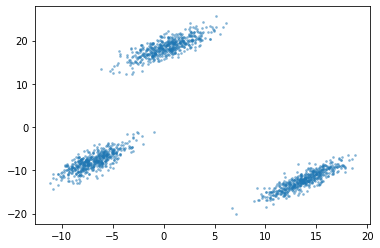

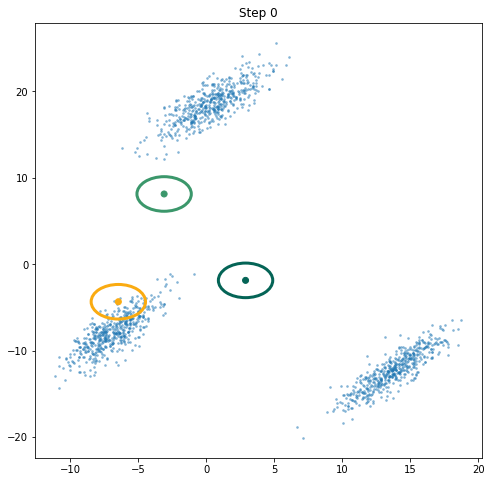

<Figure size 432x288 with 0 Axes>

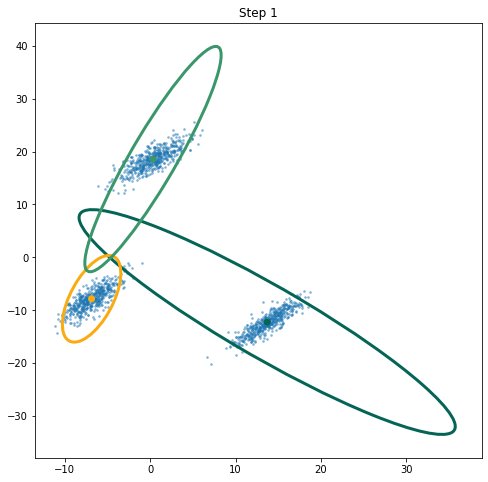

<Figure size 432x288 with 0 Axes>

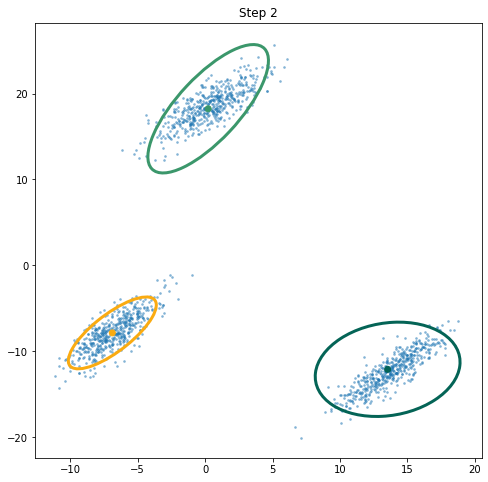

<Figure size 432x288 with 0 Axes>

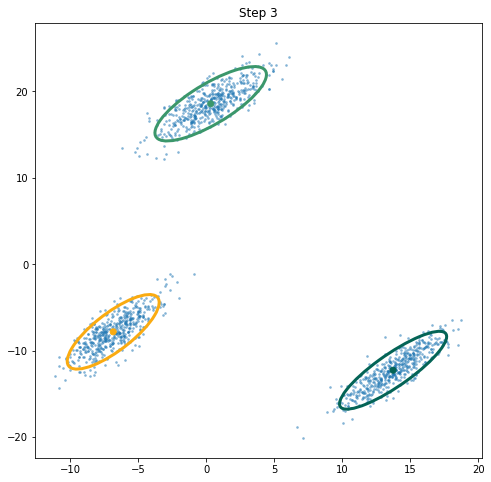

<Figure size 432x288 with 0 Axes>

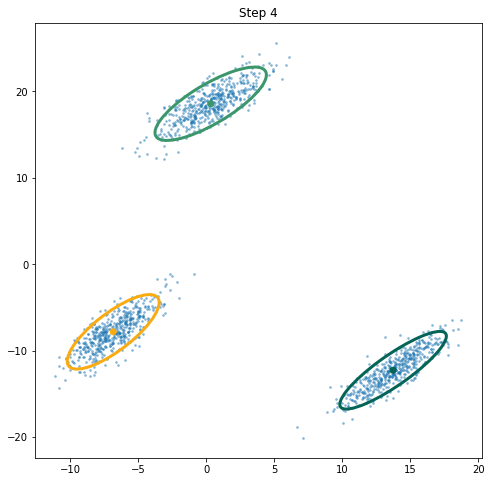

<Figure size 432x288 with 0 Axes>

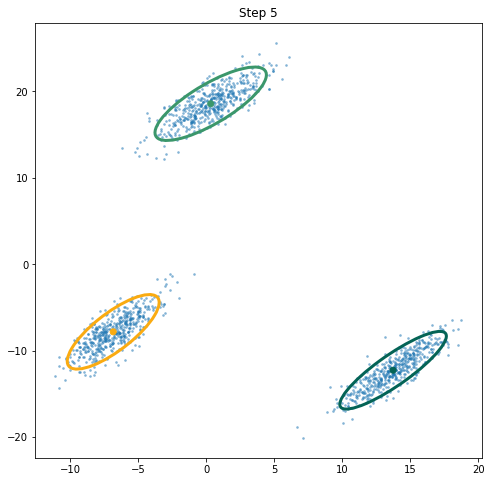

<Figure size 432x288 with 0 Axes>

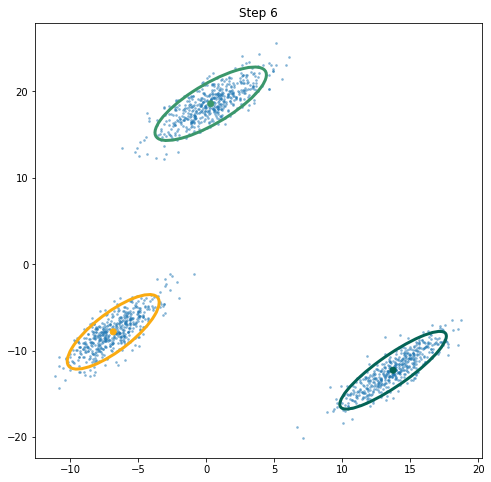

<Figure size 432x288 with 0 Axes>

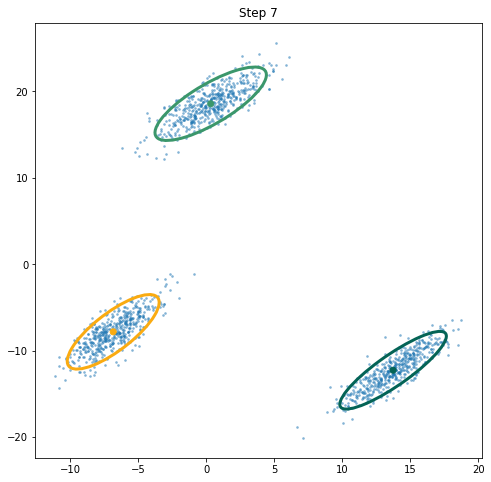

<Figure size 432x288 with 0 Axes>

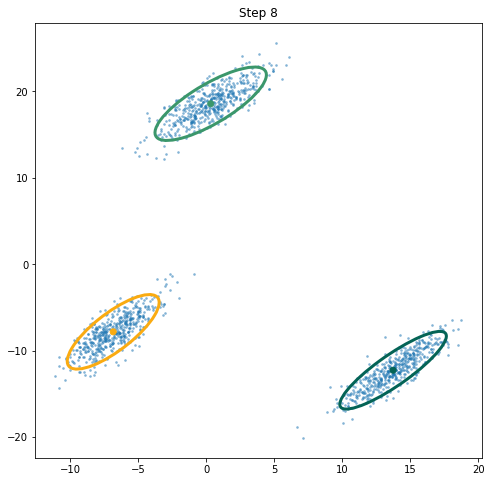

<Figure size 432x288 with 0 Axes>

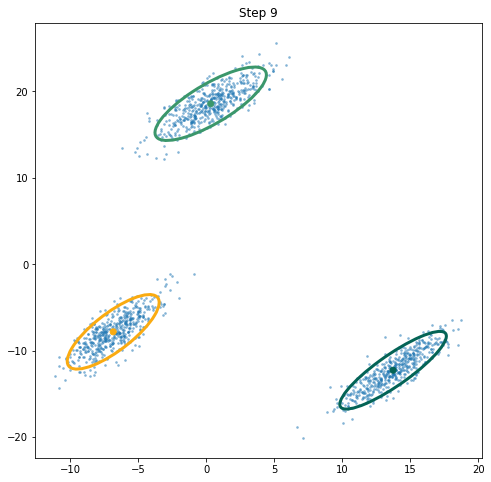

<Figure size 432x288 with 0 Axes>

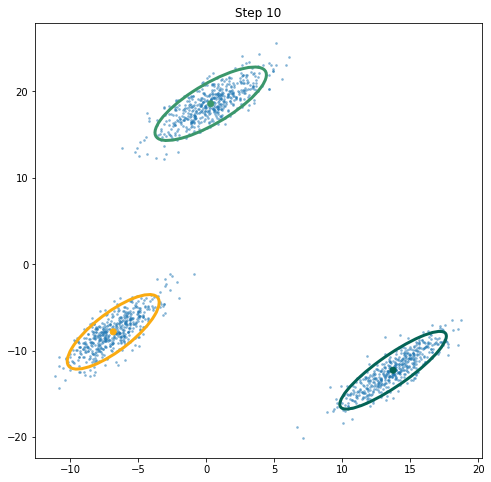

<Figure size 432x288 with 0 Axes>

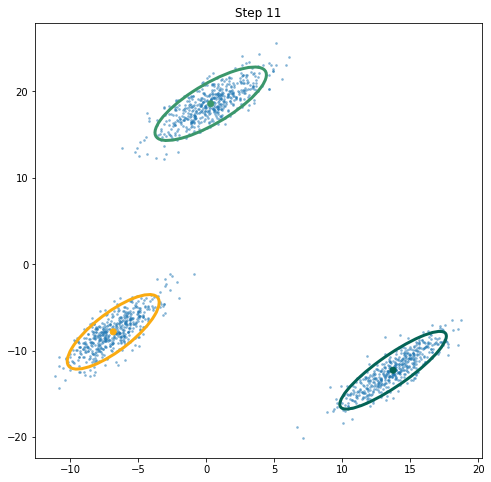

<Figure size 432x288 with 0 Axes>

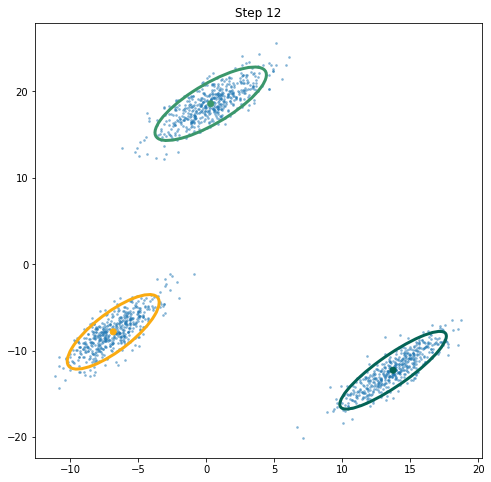

<Figure size 432x288 with 0 Axes>

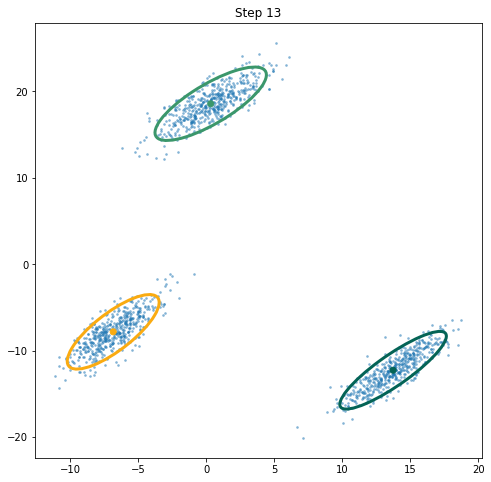

In [ ]:
def gen_data(num_of_gaussians=3, points_per_gaussian=200, mean_range=[-10, 10]):

  """
  Generates 2D points from a mixture of Gaussians.

  Args:
  - num_of_gaussians: Number of Gaussian components
  - points_per_gaussian: Number of points in each Gaussian component
  - mean_range: Range of mean values

  Returns:
  2D points data: Generated 2D points from a mixture of Gaussians
  num_of_points: Number of the generated points = Number of Gaussians * Number of points in each component
  """
  x = []
  mean = random.rand(num_of_gaussians, 2)*(mean_range[1]-mean_range[0]) + mean_range[0]
  for i in range(num_of_gaussians):
      cov = random.rand(2, 12)
      cov = np.matmul(cov, cov.T)
      _x = np.random.multivariate_normal(mean[i], cov, points_per_gaussian)
      x += list(_x)
  x = np.array(x)
  fig = plt.figure()
  ax = fig.gca()
  ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
  ax.autoscale(enable=True) 
  tot_points = num_of_gaussians*points_per_gaussian
  return x, tot_points

def plot(title):
    """Draw the data points and the fitted mixture model."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.means[:, 0], gmm.means[:, 1], c=gmm.colors_of_gaussians)
    gmm.draw(ax, lw=3)
    # ax.set_xlim((-12, 12))
    # ax.set_ylim((-12, 12))
    plt.title(title)
    plt.show()
    plt.clf()


NUM_OF_CLUSTERS = 3
POINTS_PER_CLUSTER = 500
MEAN_RANGE = [-20, 20]
X, NUM_OF_POINTS = gen_data(num_of_gaussians=NUM_OF_CLUSTERS, points_per_gaussian=POINTS_PER_CLUSTER, mean_range=MEAN_RANGE)

clients = []
for i in range(NUM_OF_POINTS):
  x = Client(data=X[i], num_of_gaussians=NUM_OF_CLUSTERS)
  clients.append(x)

gmm = GMM(parties=clients, num_of_parties=NUM_OF_POINTS, num_of_gaussians=NUM_OF_CLUSTERS)

NUM_OF_ITERATIONS = 13
# plotting the points alongside the Gaussian components
plot("Step 0")
for e in range(NUM_OF_ITERATIONS):
    gmm.e_step()
    gmm.m_step()
    plot(title="Step " + str(e+1))